In [61]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split


In [62]:
# Load features and labels
features_array = np.load('x_data.npy', allow_pickle=True)
labels_array = np.load('y_label.npy', allow_pickle=True)


In [63]:
# columns_to_remove = [
#  'font_size', 'right_gaze_point_in_user_x', 'left_gaze_point_in_user_z', 
# 'left_gaze_point_on_display_area_y', 'right_gaze_point_on_display_area_x', 
# 'right_gaze_point_in_user_z', 'right_gaze_point_in_user_y', 
#  'left_gaze_point_in_user_x', 'right_pupil_diameter', 
#  'left_gaze_origin_in_trackbox_z', 'right_gaze_origin_in_trackbox_y', 
#  'left_gaze_origin_in_trackbox_x', 'right_gaze_origin_in_user_z', 
#  'left_gaze_origin_in_user_x', 'left_gaze_origin_in_user_y', 
#  'left_gaze_origin_validity', 'right_gaze_origin_validity', 
#  'device_time_stamp', 'left_gaze_point_validity', 
#  'right_gaze_point_validity', 'left_pupil_validity', 'right_pupil_validity'
# ]


In [64]:
# processed_dataframes = []
# for df in features_array:
#   #Drop the columns if they exist, ignore errors if some columns don't exist
#   new_df = df.drop(columns=columns_to_remove, errors='ignore')
#   processed_dataframes.append(new_df)

# features_array = np.array(processed_dataframes, dtype=object)

In [65]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

lengths = [df.size for df in features_array]
k = int(np.median(lengths))
# Example of handling non-numeric data before flattening
processed_features = []
encoder = OneHotEncoder(sparse=False)  # Initialize one-hot encoder

for df in features_array:
    # Check and transform non-numeric columns if necessary
    for col in df.columns:
        if df[col].dtype == object:
            # Assuming the non-numeric data is categorical and not text like 'Times New Roman'
            transformed = encoder.fit_transform(df[[col]])
            df = pd.concat([df.drop(col, axis=1), pd.DataFrame(transformed)], axis=1)
    
    # Flatten and standardize lengths as before
    flattened = df.values.flatten()
    # Use a fixed length 'k' determined as before
    if len(flattened) > k:
        processed_features.append(flattened[:k])
    else:
        processed_features.append(np.pad(flattened, (0, k - len(flattened)), 'constant'))

X = np.array(processed_features)
y = labels_array

In [66]:
print("NaNs in X:", np.isnan(X).any())
print("Infs in X:", np.isinf(X).any())

# If there are any, you might want to consider replacing them
if np.isnan(X).any() or np.isinf(X).any():
    # Replace NaNs with the mean of the column
    col_mean = np.nanmean(X, axis=0)  # Mean ignoring NaNs
    # Find indices where NaN values are
    inds = np.where(np.isnan(X))
    # Replace NaNs with the mean of each column
    X[inds] = np.take(col_mean, inds[1])

    # Replace infinities with large finite numbers
    X[np.isinf(X)] = 1e+18  # You might choose a suitable finite number

    # Re-check
    print("NaNs in X after replacement:", np.isnan(X).any())
    print("Infs in X after replacement:", np.isinf(X).any())


NaNs in X: True
Infs in X: False
NaNs in X after replacement: False
Infs in X after replacement: False


In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [68]:
from sklearn.preprocessing import LabelEncoder

# Initialize the encoder
encoder = LabelEncoder()

# Fit and transform the labels to integers
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

# Save the encoder if you need to decode labels later
import joblib
joblib.dump(encoder, 'label_encoder.joblib')


['label_encoder.joblib']

In [69]:
# Convert the numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)  # Now y_train_encoded contains integers
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)


# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [70]:
# Example reshape, adjust depending on your specific needs and data properties

X_train_reshaped = X_train.reshape(-1, 1, 89*2, 117)  # -1 for batch size, 1 for channel, 89x91 as an example shape
X_test_reshaped = X_test.reshape(-1, 1, 89*2, 117)

# Convert reshaped data to tensors
X_train_tensor = torch.tensor(X_train_reshaped, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_reshaped, dtype=torch.float32)

# Re-create your DataLoader with the reshaped data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [71]:
# Calculate total elements and intended product from reshape dimensions
total_elements = X_train.size
intended_product = 1 * 89*2 * 117
num_intended_samples = total_elements / intended_product

print(f"Total elements in X_train: {total_elements}")
print(f"Expected samples after reshape: {num_intended_samples}")
print(f"Actual number of labels: {y_train_tensor.shape[0]}")


Total elements in X_train: 20451132
Expected samples after reshape: 982.0
Actual number of labels: 982


In [72]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(39424, 128)  # Update this to match the flattened output size 15488
        self.fc2 = nn.Linear(128, 10)  # Assuming 10 classes

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [73]:
model = CNN()
lossarr = []
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Define the training loop
def train_model(num_epochs):
    model.train()
    for epoch in range(num_epochs):
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

        print(f'Epoch {epoch+1}, Loss: {loss.item()}')
        lossarr.append(loss.item())

# Train the model
train_model(10)  # Adjust the number of epochs as needed


Epoch 1, Loss: 1.845198154449463
Epoch 2, Loss: 1.6153279542922974
Epoch 3, Loss: 1.6716018915176392
Epoch 4, Loss: 1.5300556421279907
Epoch 5, Loss: 1.2346596717834473
Epoch 6, Loss: 1.3142987489700317
Epoch 7, Loss: 1.732447862625122
Epoch 8, Loss: 1.4128203392028809
Epoch 9, Loss: 1.1543396711349487
Epoch 10, Loss: 1.3397468328475952
Epoch 11, Loss: 0.9671556353569031
Epoch 12, Loss: 1.5419501066207886
Epoch 13, Loss: 1.2541651725769043
Epoch 14, Loss: 1.297908067703247
Epoch 15, Loss: 1.5237469673156738
Epoch 16, Loss: 1.069031000137329
Epoch 17, Loss: 1.4027706384658813
Epoch 18, Loss: 1.0254079103469849
Epoch 19, Loss: 1.1523813009262085
Epoch 20, Loss: 1.0088311433792114
Epoch 21, Loss: 1.3403773307800293
Epoch 22, Loss: 1.459275722503662
Epoch 23, Loss: 0.9953863620758057
Epoch 24, Loss: 1.1629148721694946
Epoch 25, Loss: 1.2601354122161865
Epoch 26, Loss: 1.108699083328247
Epoch 27, Loss: 1.0080811977386475
Epoch 28, Loss: 1.2343897819519043
Epoch 29, Loss: 1.3835129737854004


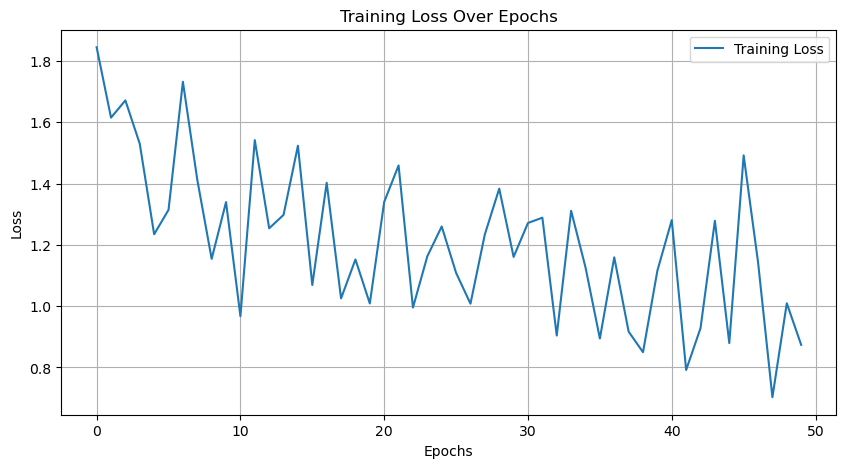

In [74]:
import matplotlib.pyplot as plt

# Plotting the training loss
plt.figure(figsize=(10, 5))
plt.plot(lossarr, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [75]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, target in test_loader:
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    print(f'Accuracy of the model on the test images: {100 * correct / total}%')



Accuracy of the model on the test images: 33.333333333333336%


In [76]:
class DenseNetwork(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size):
        super(DenseNetwork, self).__init__()
        self.layers = nn.Sequential()  # Use Sequential for simpler architecture definition

        # Adding the first layer
        self.layers.add_module("linear_0", nn.Linear(input_size, hidden_layers[0]))
        self.layers.add_module("relu_0", nn.ReLU())

        # Adding subsequent hidden layers
        for i in range(1, len(hidden_layers)):
            self.layers.add_module(f"linear_{i}", nn.Linear(hidden_layers[i-1], hidden_layers[i]))
            self.layers.add_module(f"relu_{i}", nn.ReLU())

        # Adding the output layer
        self.layers.add_module("output", nn.Linear(hidden_layers[-1], output_size))

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Ensure input is flattened
        return self.layers(x)


In [77]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Initialize the Dense Network
# Assuming the shape of each data sample in X_train_reshaped is (1, 89, 91)
input_size = 1 * 89*2 * 117  # Calculate the total number of features after flattening
model = DenseNetwork(input_size, [256, 128], 10)  # Now the input size should be correct

lossarr2 = []
# Training loop
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(100):  # Define num_epochs as per your training configuration
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")
    lossarr2.append(loss.item())


Epoch 1, Loss: 145.12489318847656
Epoch 2, Loss: 85.7803955078125
Epoch 3, Loss: 33.79141616821289
Epoch 4, Loss: 22.977947235107422
Epoch 5, Loss: 15.539514541625977
Epoch 6, Loss: 32.143409729003906
Epoch 7, Loss: 10.971599578857422
Epoch 8, Loss: 7.716823101043701
Epoch 9, Loss: 16.688905715942383
Epoch 10, Loss: 10.444843292236328
Epoch 11, Loss: 6.019704818725586
Epoch 12, Loss: 3.6958909034729004
Epoch 13, Loss: 3.218932867050171
Epoch 14, Loss: 6.433620929718018
Epoch 15, Loss: 10.219244003295898
Epoch 16, Loss: 3.6593360900878906
Epoch 17, Loss: 7.663903713226318
Epoch 18, Loss: 2.7127716541290283
Epoch 19, Loss: 1.990524411201477
Epoch 20, Loss: 3.1774232387542725
Epoch 21, Loss: 1.9244641065597534
Epoch 22, Loss: 1.4658650159835815
Epoch 23, Loss: 1.795200228691101
Epoch 24, Loss: 1.3962030410766602
Epoch 25, Loss: 1.7381901741027832
Epoch 26, Loss: 1.0644876956939697
Epoch 27, Loss: 1.4012739658355713
Epoch 28, Loss: 2.2952773571014404
Epoch 29, Loss: 1.5561795234680176
Epoc

KeyboardInterrupt: 

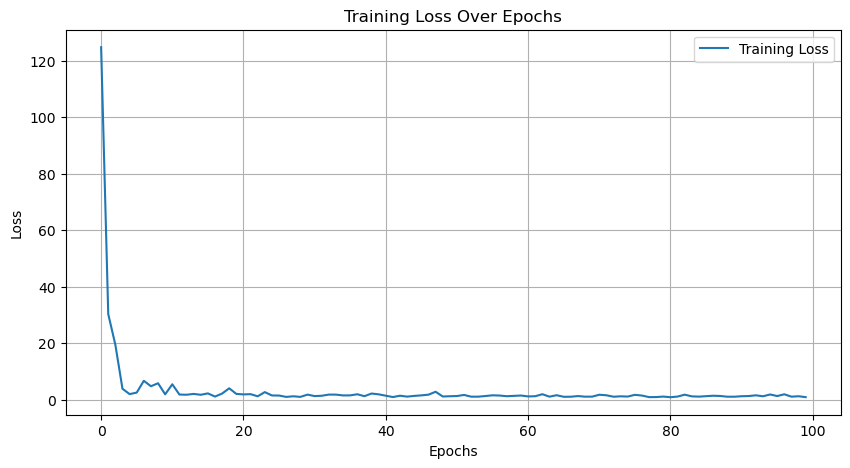

In [ ]:
import matplotlib.pyplot as plt

# Plotting the training loss
plt.figure(figsize=(10, 5))
plt.plot(lossarr2, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, target in test_loader:
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    print(f'Accuracy of the model on the test images: {100 * correct / total}%')

Accuracy of the model on the test images: 41.46341463414634%


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score



# Flatten the data
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

# Initialize the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=500,  # Number of trees in the forest
                                  random_state=42,   # Seed for reproducibility
                                  n_jobs=-1)         # Use all available cores

# Train the model on the flattened data
rf_model.fit(X_train_flattened, y_train)

# Predict on the test set using the flattened test data
y_pred = rf_model.predict(X_test_flattened)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

#make confusion matrix!

Accuracy: 0.5934959349593496
                        precision    recall  f1-score   support

      immersive - easy       0.67      0.67      0.67         3
      immersive - hard       1.00      0.50      0.67        12
    immersive - normal       1.00      0.43      0.60         7
       skimming - easy       0.55      0.53      0.54        55
       skimming - hard       0.60      0.55      0.57        71
     skimming - normal       0.57      0.70      0.63        93
skimming - really hard       1.00      0.40      0.57         5

              accuracy                           0.59       246
             macro avg       0.77      0.54      0.61       246
          weighted avg       0.62      0.59      0.59       246



In [ ]:
#import xgboost as xgb
#from sklearn.metrics import classification_report, accuracy_score

#from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
#label_encoder = LabelEncoder()

# Fit label encoder and transform the target variable
#y_train_encoded = label_encoder.fit_transform(y_train)

# Now, y_train_encoded will contain numerical labels instead of strings
# You can use these encoded labels to fit your XGBoost classifier



# Configure XGBoost as a Random Forest
#xgb_rf = xgb.XGBClassifier(
 #   n_estimators=100,          # Number of trees to train
 #   num_parallel_tree=100,     # Number of trees to use in parallel (same as n_estimators)
 #   subsample=1.0,             # Use all data for training each tree
 #   colsample_bytree=0.8,      # Fraction of features to use for each tree
 #   max_depth=6,               # Depth of each tree
   # booster='gbtree',          # Tree booster
  #  objective='multi:softmax', # Objective function for multi-class classification
  #  use_label_encoder=False,   # Handle deprecation warning for label encoding
  #  eval_metric='mlogloss',    # Metric for multi-class classification
 #   random_state=42            # Seed for reproducibility
#)

# Assuming X_train_flattened and y_train are already defined and suitable for training
#xgb_rf.fit(X_train_flattened, y_train_encoded)

# Predict on the test set
#y_pred = xgb_rf.predict(X_test_flattened)

# Evaluate the model
#accuracy = accuracy_score(y_test, y_pred)
#print("Accuracy:", accuracy)
#print(classification_report(y_test, y_pred))


In [ ]:
from collections import Counter

# Count the occurrences of each label
label_counts = Counter(labels_array)
label_counts

Counter({'immersive - normal': 53,
         'immersive - easy': 27,
         'immersive - hard': 34,
         'skimming - normal': 450,
         'skimming - easy': 278,
         'skimming - hard': 360,
         'immersive - really hard': 2,
         'skimming - really hard': 24})

In [ ]:
450/len(labels_array)

0.36644951140065146